In [32]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'slibkind':
    p = '/Users/slibkind/Documents/'
##ADD YOUR PATH TO CODE REPOS HERE

net = 'binary_inputs'
PATH_YANGNET = os.path.join(p,'code/sophie-nets',net) 
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools

In [33]:
figpath = os.path.join(PATH_YANGNET,'test')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [34]:
#WHERE IS THE NETWORK
rnn_type = 'LeakyRNN' 
activation = 'softplus'
w_init = 'randgauss'
ruleset = 'basic' # what set of tasks (look up in task.py)
n_rnn = str(256)
l2w = -7.0        # exponent of regularization terms
l2h = -7.0
l1w = 0
l1h = 0
lr = -7.0   # learning rate
seed = str(0)
rule_trains = [rules_dict['basic'][1],rules_dict['basic'][3]] # what rules to train on
rule_trains_str = '_'.join(rule_trains)
sigma_rec = 1/20
sigma_x = 2/20
w_rec_coeff = .9

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)
net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

dir_specific_all = os.path.join(ruleset,rnn_type,activation,
    w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2)

m = os.path.join(p,'data','sophie-nets',net,'data',dir_specific_all,str(seed))


In [35]:
#THIS IS SOME GENERAL CODE THAT WILL GET YOU LOTS OF VARIABLES YOU'LL WANT TO LOOK AT

rule = 'fdgo' # SET A PARTICULAR TASK OF INTEREST

model = Model(m)
with tf.Session() as sess:
    model.restore()      # set up tf graph with model m
    var_list = model.var_list # variables learned over training (a tf "function")

    # params = [W_rec + W_in, b_in, W_out, b_out]
    params = [sess.run(var) for var in var_list]  # saves the values of the variables so we can look at them
    hparams = model.hp  # the hyperparameters

    # generates inputs, outputs, other cool stuff (trial.__dict__.keys())
    # this function is defined in task.py if you want to mess with the inputs
    trial = generate_trials(rule, hparams, mode='random', noise_on=False,batch_size = 200) # alternate mode = 'test' which goes through all possible stimuli

    feed_dict = tools.gen_feed_dict(model, trial, hparams) # set up tf graph

    # run the model
    # sess.run( list of things I want to inspect, feed_dict = feed_dict)
    h, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #HIDDEN STATE, OUTPUT (n_TIME, n_TRIAL, n_UNIT)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt


In [36]:
# VANILLA RNN CODE FOR MESSING WITH INPUTS ETC.

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delayanti', hparams, mode='random', noise_on=False, batch_size = 50, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]  # [input weights , recurrent weights] 7+256, 256
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt


In [37]:
from mpl_toolkits.mplot3d import Axes3D

def gen_trial_set(ri_set): # SAME STIM TRIALS FROM 2 DIFF TASKS
    rule1 = rules_dict[ruleset][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

def gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num): #MAKE AXES

    h_A = get_h_epoch(m,trial_set[ri_axs],epoch_list[ri_axs],trial_num[ri_axs])
    h_end = h_A[:,-1] - h_A[:,0]
    h_B = get_h_epoch(m,trial_set[1-ri_axs],epoch_list[1-ri_axs],trial_num[1-ri_axs])
    h_diff = h_B[:,-1] - h_A[:,-1]

    D_fp = np.concatenate((h_diff[:,np.newaxis],h_end[:,np.newaxis]),axis = 1)
    D_fp_qr,_ = LA.qr(D_fp)
    
    return D_fp_qr

def get_single_task_fp_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename

def get_interp_filename(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(n_stim_per_ring+1)

    rule1 = rules_dict[ruleset][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict[ruleset][np.argmax(trial2.x[0,0,stim_size:])]
    # ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    # ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    # filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(t_set[0])+'_x'+str(t_set[1])

    return filename

def get_h_epoch(m,trial,epoch,t_num): #GET HIDDEN STATE TRAJECTORY FROM PARTICULAR TASK PERIOD
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    h_epoch = x[:,t_num,T_inds]
    return h_epoch

def find_closest_fp_loc(h_end,x_star):

    closest_fp = np.argmin([LA.norm(h_end - x_star[fp,:]) for fp in range(len(x_star))])
    closest_fp_loc = x_star[closest_fp,:]
        
    return closest_fp, closest_fp_loc

def interp_h_tasks_w_context(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                             q_thresh = 1e-6,linestyle = ['-',':'],al = .3,lw = 3,tit = [],ri_axs = 1, 
                             step_file = 'interp_tasks_small_init_mov',
                             show_trajectories = True):

    fig_width = 10
    fig_height = 12
    fig = plt.figure(figsize=(fig_width,fig_height),tight_layout=True,facecolor='white')
    ax_fps = fig.add_axes([0,.2,.8,.8], projection='3d');
    plt.rcParams.update({'font.size': 14})
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('hsv')
    q_tol_name = 'tol_q_e_6.0'
    axs = 'pca_h'
    
    tasks_str = '_'.join([rules_dict[ruleset][ri_set[0]],rules_dict[ruleset][ri_set[1]]])

    _, rule_name1, _, _ = take_names(epoch_list[0],rules_dict[ruleset][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict[ruleset][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict[ruleset][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    
    # sets the axes for the graph
    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0] # from the start to the end of the trajectory (see figure)
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    closest_fp_loc = np.zeros((2,len(D_fp_qr)))
    for ri in [1,0]:
        rule = rules_dict[ruleset][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))
        
        h_end = x[:,trial_num[ri],T_inds[-1]]
        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[1]],trial_num)
        save_dir = os.path.join(m,step_file,tasks_str)
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(int(ri*(n_interp-1)))+'.npz'))
        x_star = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        _, closest_fp_loc[ri] = find_closest_fp_loc(h_end,x_star[fp_inds,:])

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0] #this avoids trials with low signal stimuli
            
    AB = LA.norm(closest_fp_loc[0,:] - closest_fp_loc[1,:]) #distance between two closest (most relevant?) fps)

    for step_i in range(n_interp):

        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp) # this interpolates the inputs between the two trials
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        # run the network with the interpolated inputs and
        #     initial condition fixed to be the initial condition of the first task
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams['dt']/hparams['tau']) 

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[1]],trial_num)
        save_dir = os.path.join(m,step_file,tasks_str)
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        step_i_frac = step_i/(n_interp-1)
        if show_trajectories: 
          ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                    linewidth = 3, alpha = .5,linestyle = '-',c = c)
          ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                    linewidth = 1, alpha = al,linestyle = '-',c = 'k')
          ax_fps.scatter(step_i_frac,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),
                        s = 20,c = 'k',marker = '^')
          ax_fps.scatter(step_i_frac,np.dot(h_t[0,:],D_diff),np.dot(h_t[0,:],D_end),
                        s = 20,c = 'k',marker = 'x')

        for fp_ind in range(len(fp_inds)):
            
            fp = fp_inds[fp_ind]
            
#             CA = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[0,:])
#             CB = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[1,:])
            
#             if CA+CB < 1.2*AB: #only plotting fp in an ellipse around end of trajecory - better way to do this?
            
            dst_scale = 200 #messing around w scaling fps, make them HUUUGe

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                facecolors='w' #unstable fps
            else:
                facecolors=c #stable fps

            ax_fps.scatter(step_i_frac,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                          s = dst_scale, edgecolors = c, facecolors = facecolors, alpha = .8)

    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xticklabels([0,.2,.4,.6,.8,1],fontdict={'fontsize':11})
    ax_fps.set_yticklabels([],{'fontsize':8})
    ax_fps.set_zticklabels([],{'fontsize':8})
    ax_fps.set_xlabel(r"Task Input $\alpha$",fontsize = 14)
    ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,labelpad = -1,fontsize = 14)
    ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",labelpad = -1,fontsize = 14)
#     ax_fps.view_init(-153, -163)

    
    step_file='interp_h_clip'
    if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
        os.makedirs(os.path.join(figpath,step_file,tasks_str))

    figname = 'interp_stim_fps'+'_'+tasks_str
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
    return ax_fps

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dt

/Users/slibkind/opt/anaconda3/envs/motifs/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


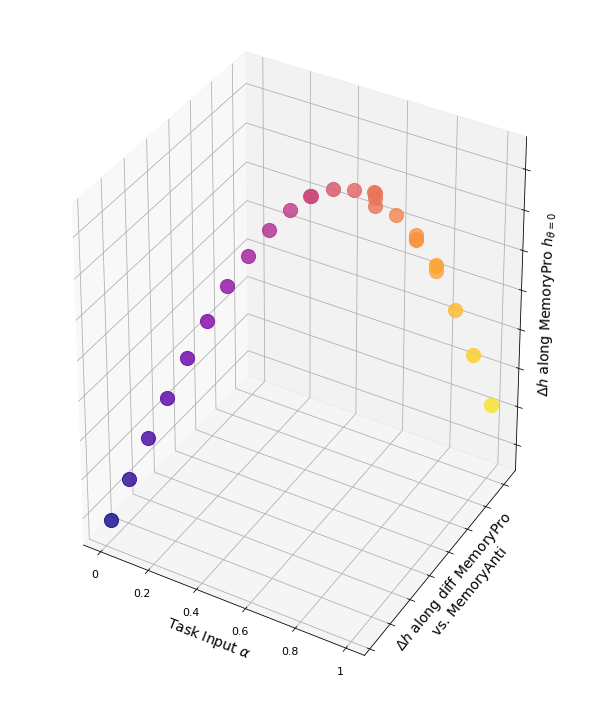

In [38]:
from tools_lnd import gen_trials_from_model_dir,make_FP_axs,take_names,same_stim_trial,\
gen_X_from_model_dir,get_T_inds,comp_eig_decomp

"""
need to run fixed point finder before running analysis on a new epoch or trial
do this by running the script in interp_tasks_small_init_stim.py with desired trial and epoch

saved in the folder with the network

use 
  * interp_tasks_small_init_stim.py for keeping the stimulus constant 
  * inter_tasks_small_init_mov.py   for keeping the response direction constant
"""

ri_set = [1,3]  # rule index set, indexing into rules_dict
trial_set = gen_trial_set(ri_set)
epoch_list = ['stim1','stim1'] # find these names in trial.py
trial_num = [0,0]
interp_h_tasks_w_context(ri_set,trial_num,epoch_list,n_interp = 20,ri_axs = 0, 
                             step_file = 'interp_tasks_small_init_stim',
                             show_trajectories=False)



In [39]:
trial_num = [0,1]
rule1 = rules_dict[ruleset][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[1]],trial_num)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/slibkind/Documents/data/sophie-nets/binary_inputs/data/basic/LeakyRNN/softplus/randgauss/2_tasks/256_n_rnn/lr7.0l2_w7.0_h7.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.9_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(263, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dt

'delaygo_delayanti_stim1_stim1_x0_x1'

In [ ]:
def interp_h_tasks_w_context(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                             q_thresh = 1e-6,linestyle = ['-',':'],al = .3,lw = 3,tit = [],ri_axs = 1, 
                             step_file = 'interp_tasks_small_init_mov',
                             show_trajectories = True):

    fig_width = 10
    fig_height = 12
    fig = plt.figure(figsize=(fig_width,fig_height),tight_layout=True,facecolor='white')
    ax_fps = fig.add_axes([0,.2,.8,.8], projection='3d');
    plt.rcParams.update({'font.size': 14})
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('hsv')
    q_tol_name = 'tol_q_e_6.0'
    axs = 'pca_h'
    
    tasks_str = '_'.join([rules_dict[ruleset][ri_set[0]],rules_dict[ruleset][ri_set[1]]])

    _, rule_name1, _, _ = take_names(epoch_list[0],rules_dict[ruleset][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict[ruleset][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict[ruleset][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    
    # sets the axes for the graph
    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0] # from the start to the end of the trajectory (see figure)
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    closest_fp_loc = np.zeros((2,len(D_fp_qr)))
    for ri in [1,0]:
        rule = rules_dict[ruleset][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))
        
        h_end = x[:,trial_num[ri],T_inds[-1]]
        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[1]],trial_num)
        save_dir = os.path.join(m,step_file,tasks_str)
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(int(ri*(n_interp-1)))+'.npz'))
        x_star = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        _, closest_fp_loc[ri] = find_closest_fp_loc(h_end,x_star[fp_inds,:])

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0] #this avoids trials with low signal stimuli
            
    AB = LA.norm(closest_fp_loc[0,:] - closest_fp_loc[1,:]) #distance between two closest (most relevant?) fps)

    for step_i in range(n_interp):

        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp) # this interpolates the inputs between the two trials
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        # run the network with the interpolated inputs and
        #     initial condition fixed to be the initial condition of the first task
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams['dt']/hparams['tau']) 

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[1]],trial_num)
        save_dir = os.path.join(m,step_file,tasks_str)
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        step_i_frac = step_i/(n_interp-1)
        if show_trajectories: 
          ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                    linewidth = 3, alpha = .5,linestyle = '-',c = c)
          ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                    linewidth = 1, alpha = al,linestyle = '-',c = 'k')
          ax_fps.scatter(step_i_frac,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),
                        s = 20,c = 'k',marker = '^')
          ax_fps.scatter(step_i_frac,np.dot(h_t[0,:],D_diff),np.dot(h_t[0,:],D_end),
                        s = 20,c = 'k',marker = 'x')

        for fp_ind in range(len(fp_inds)):
            
            fp = fp_inds[fp_ind]
            
#             CA = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[0,:])
#             CB = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[1,:])
            
#             if CA+CB < 1.2*AB: #only plotting fp in an ellipse around end of trajecory - better way to do this?
            
            dst_scale = 200 #messing around w scaling fps, make them HUUUGe

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                facecolors='w' #unstable fps
            else:
                facecolors=c #stable fps

            ax_fps.scatter(step_i_frac,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                          s = dst_scale, edgecolors = c, facecolors = facecolors, alpha = .8)

    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xticklabels([0,.2,.4,.6,.8,1],fontdict={'fontsize':11})
    ax_fps.set_yticklabels([],{'fontsize':8})
    ax_fps.set_zticklabels([],{'fontsize':8})
    ax_fps.set_xlabel(r"Task Input $\alpha$",fontsize = 14)
    ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,labelpad = -1,fontsize = 14)
    ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",labelpad = -1,fontsize = 14)
#     ax_fps.view_init(-153, -163)

    
    step_file='interp_h_clip'
    if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
        os.makedirs(os.path.join(figpath,step_file,tasks_str))

    figname = 'interp_stim_fps'+'_'+tasks_str
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
    return ax_fps